In [16]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch

%config InlineBackend.figure_format = 'retina'

class MaskedImageDataset(Dataset):
    def __init__(self, base_dataset, mask_ratio=0.75):
        self.base = base_dataset
        self.mask_ratio = mask_ratio

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx):
        img, _ = self.base[idx]             # ignore label
        mask = torch.rand_like(img[:1]) > self.mask_ratio  # [1,H,W]
        masked_img = img * mask             # zero out masked pixels
        return masked_img, img              # (X=masked, Y=original)


In [32]:
from torchvision import datasets
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

from torch.utils.data import Subset

# full CIFAR10
train_base = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_base  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# take first 1000 samples from each
train_small = Subset(train_base, range(1000))
test_small  = Subset(test_base, range(1000))

# wrap with masking dataset
train_masked = MaskedImageDataset(train_small, mask_ratio=0.75)
test_masked  = MaskedImageDataset(test_small,  mask_ratio=0.75)

# dataloaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_masked, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_masked,  batch_size=16, shuffle=False)

print(len(train_loader.dataset), len(test_loader.dataset))


1000 1000


torch.Size([3, 224, 224]) torch.Size([3, 224, 224])


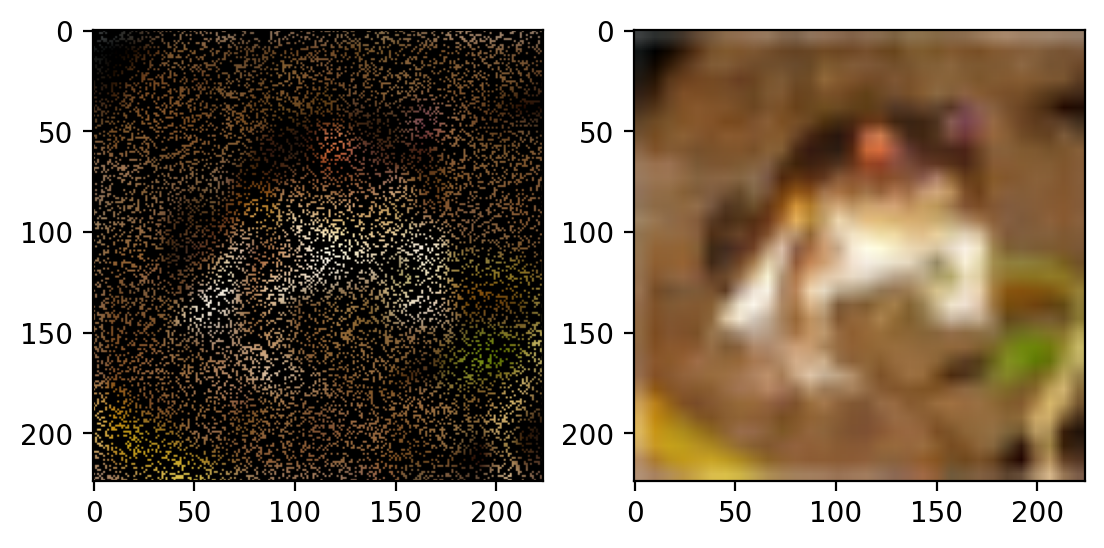

In [33]:
x, y = train_masked[0]
print(x.shape, y.shape)  # both [3,224,224]

import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(x.permute(1,2,0))  # masked
plt.subplot(1,2,2)
plt.imshow(y.permute(1,2,0))  # original
plt.show()

In [47]:
import torch.nn as nn

class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # 112×112
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 56×56
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),# 28×28
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), # 56×56
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 112×112
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),   # 224×224
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


In [55]:
model = SimpleAutoencoder()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = model.to(device)


In [56]:
def visualize_reconstruction(model, dataset, idx=0, device='cpu'):
    """Visualize one reconstruction from a masked dataset."""
    model.eval()

    x_masked, y_full = dataset[idx]
    x_masked = x_masked.unsqueeze(0).to(device)
    y_full = y_full.unsqueeze(0).to(device)

    with torch.no_grad():
        recon = model(x_masked)

    # Plot side-by-side
    plt.figure(figsize=(9, 3))
    imgs = [x_masked[0], y_full[0], recon[0]]
    titles = ["Masked", "Original", "Reconstructed"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(imgs[i].permute(1, 2, 0).cpu().clamp(0, 1))
        plt.title(titles[i])
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    
    

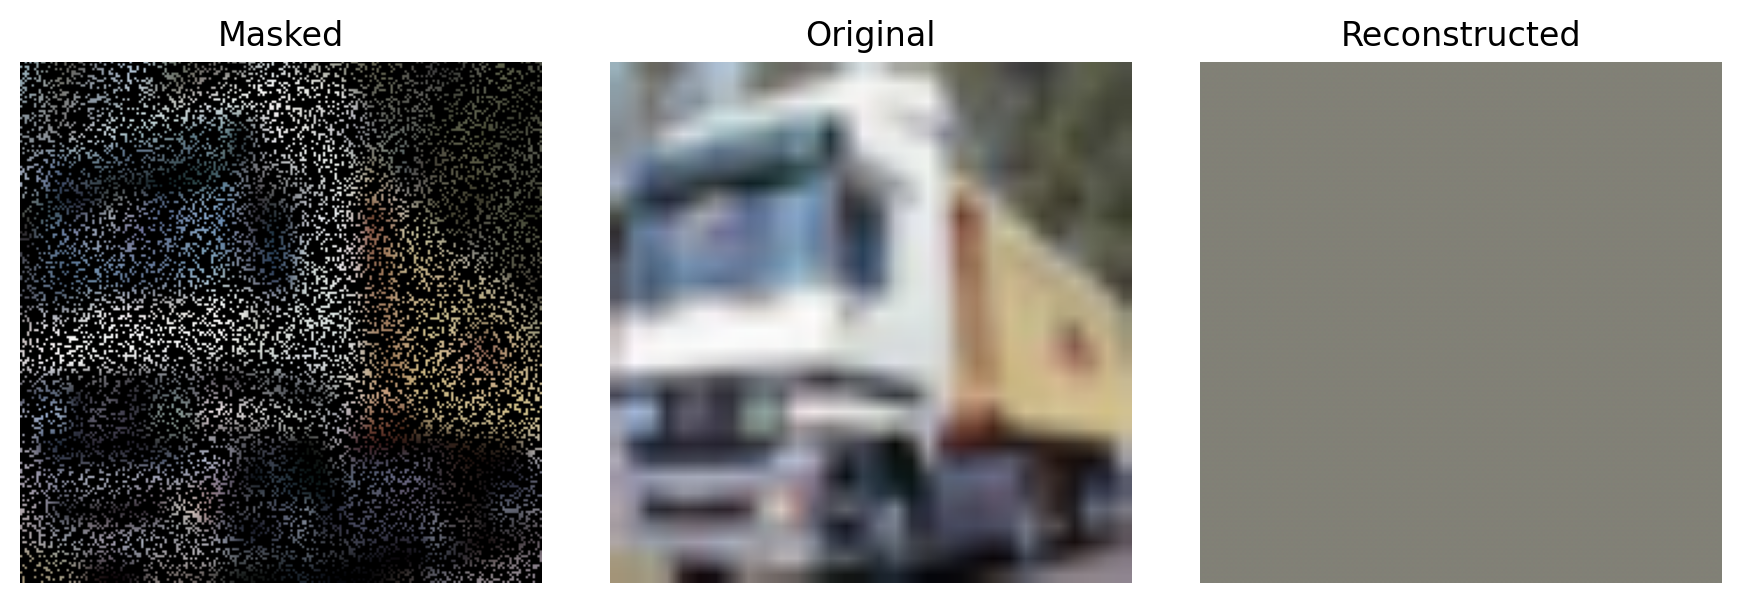

In [57]:
visualize_reconstruction(model, train_masked, idx=1, device=device)

In [66]:
model = SimpleAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

def train_autoencoder(model, train_loader, optimizer, criterion, device, epochs=5):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0
        for x_masked, y_full in train_loader:
            x_masked, y_full = x_masked.to(device), y_full.to(device)

            # Forward → Backward → Optimize
            pred = model(x_masked)
            loss = criterion(pred, y_full)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x_masked.size(0)

        epoch_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f}")
        
train_autoencoder(model, train_loader, optimizer, criterion, device, epochs=10)



Epoch 1/10 | Train Loss: 0.0397
Epoch 2/10 | Train Loss: 0.0257
Epoch 3/10 | Train Loss: 0.0226
Epoch 4/10 | Train Loss: 0.0211
Epoch 5/10 | Train Loss: 0.0200
Epoch 6/10 | Train Loss: 0.0193
Epoch 7/10 | Train Loss: 0.0191
Epoch 8/10 | Train Loss: 0.0191
Epoch 9/10 | Train Loss: 0.0189
Epoch 10/10 | Train Loss: 0.0182


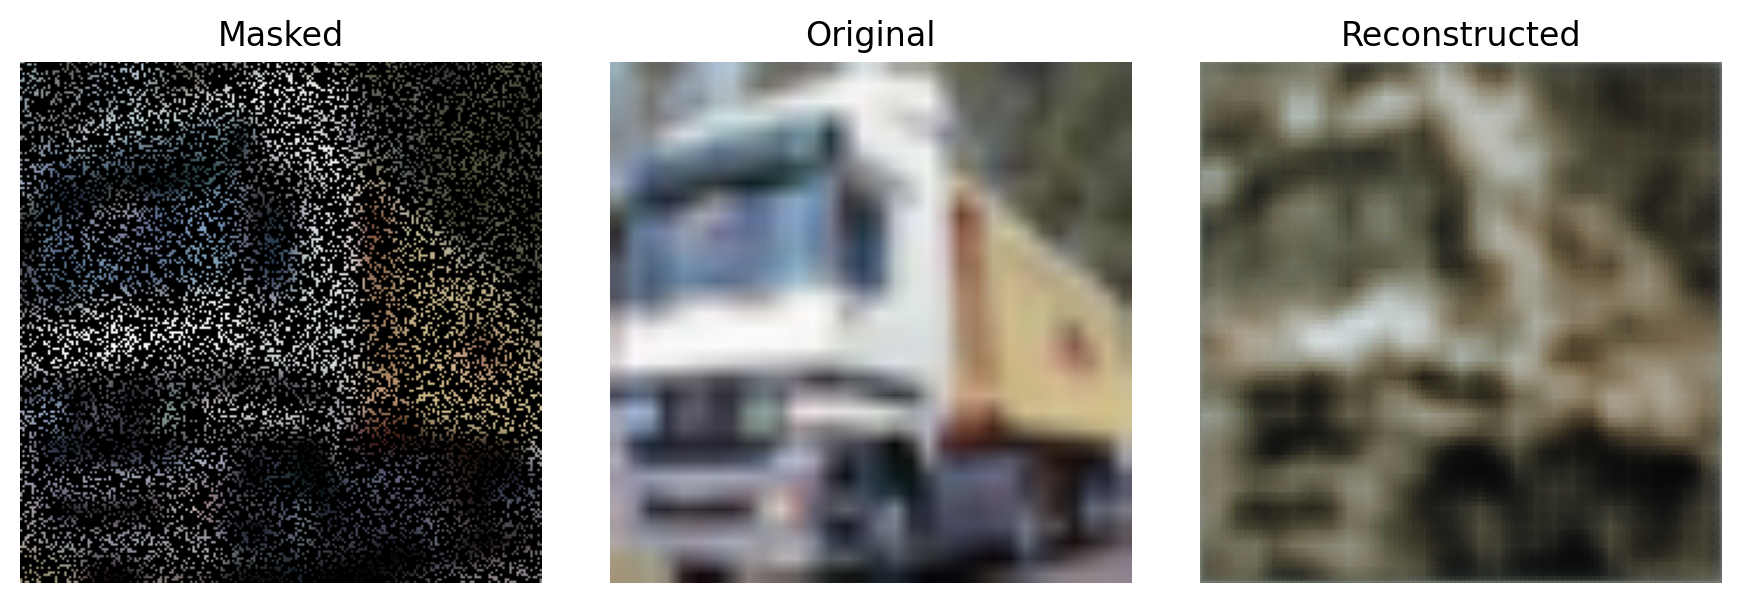

In [67]:
visualize_reconstruction(model, train_masked, idx=1, device=device)


Now, let us improve the model by adding skip connections like in U-Net.

In [68]:
import torch.nn.functional as F

class SkipAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(3, 32, 4, 2, 1)
        self.enc2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.enc3 = nn.Conv2d(64, 128, 4, 2, 1)

        self.dec3 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.dec2 = nn.ConvTranspose2d(64+64, 32, 4, 2, 1)
        self.dec1 = nn.ConvTranspose2d(32+32, 3, 4, 2, 1)

    def forward(self, x):
        x1 = F.relu(self.enc1(x))      # 112x112
        x2 = F.relu(self.enc2(x1))     # 56x56
        x3 = F.relu(self.enc3(x2))     # 28x28
        y3 = F.relu(self.dec3(x3))     # 56x56
        y2 = F.relu(self.dec2(torch.cat([y3, x2], 1)))  # skip
        y1 = torch.sigmoid(self.dec1(torch.cat([y2, x1], 1)))
        return y1


In [70]:
model = SkipAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

train_autoencoder(model, train_loader, optimizer, criterion, device, epochs=10)

Epoch 1/10 | Train Loss: 0.0449
Epoch 2/10 | Train Loss: 0.0283
Epoch 3/10 | Train Loss: 0.0236
Epoch 4/10 | Train Loss: 0.0218
Epoch 5/10 | Train Loss: 0.0195
Epoch 6/10 | Train Loss: 0.0187
Epoch 7/10 | Train Loss: 0.0174
Epoch 8/10 | Train Loss: 0.0173
Epoch 9/10 | Train Loss: 0.0164
Epoch 10/10 | Train Loss: 0.0159


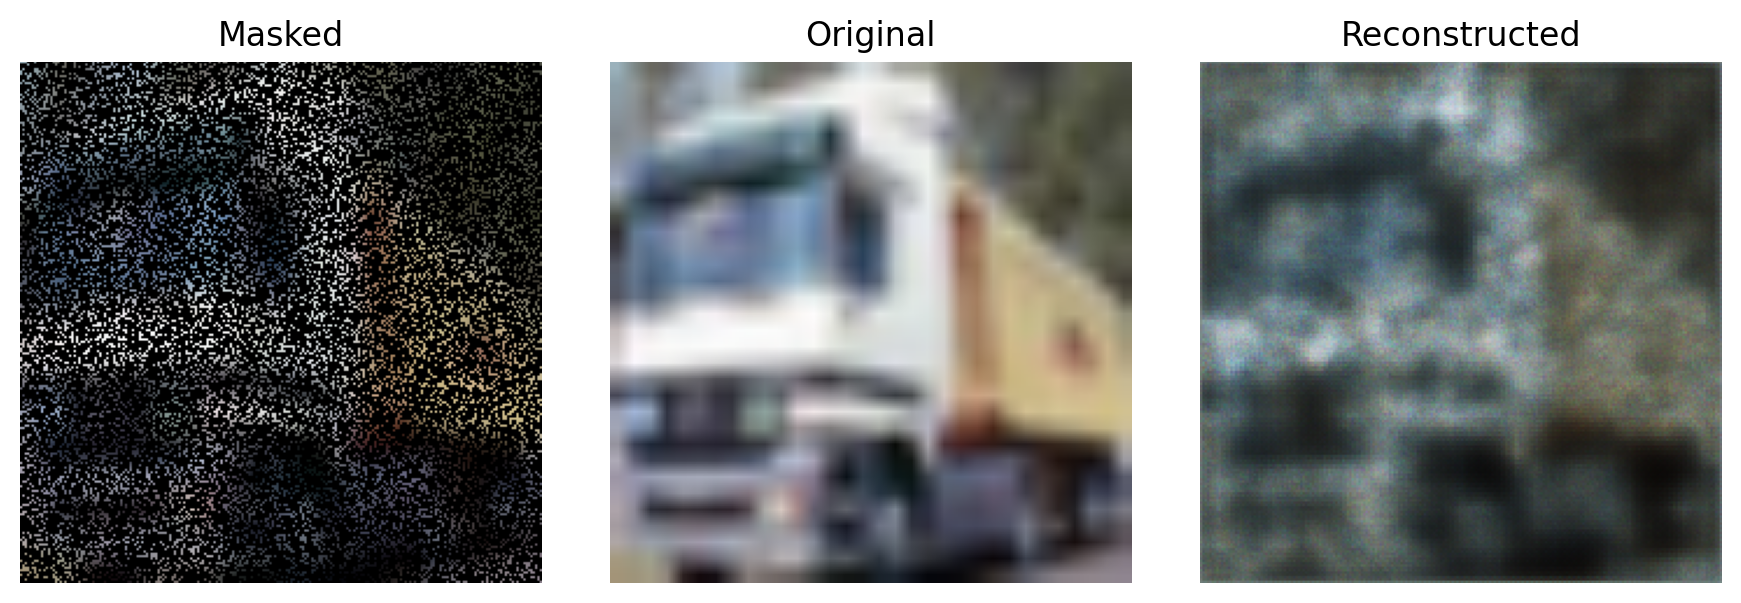

In [71]:
visualize_reconstruction(model, train_masked, idx=1, device=device)

We can see that the skip connections help a lot in reconstructing the original image from the masked input. The colors match much better and the details are clearer.

### Mask out entire patches

In [72]:
class PatchMaskedDataset(Dataset):
    def __init__(self, base_dataset, patch_size=16, mask_ratio=0.75):
        self.base_dataset = base_dataset
        self.patch_size = patch_size
        self.mask_ratio = mask_ratio

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]       # we don’t use labels for MAE
        C, H, W = img.shape
        assert H % self.patch_size == 0 and W % self.patch_size == 0

        # --- Split into patches ---
        h_patches = H // self.patch_size
        w_patches = W // self.patch_size
        total_patches = h_patches * w_patches

        # --- Choose patches to mask ---
        num_mask = int(total_patches * self.mask_ratio)
        mask_indices = np.random.choice(total_patches, num_mask, replace=False)

        # --- Make copy for masked version ---
        img_masked = img.clone()
        for idx_mask in mask_indices:
            r = idx_mask // w_patches
            c = idx_mask % w_patches
            y0, y1 = r * self.patch_size, (r + 1) * self.patch_size
            x0, x1 = c * self.patch_size, (c + 1) * self.patch_size
            img_masked[:, y0:y1, x0:x1] = 0.0   # zero out full patch

        return img_masked, img

In [73]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_base = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_base  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Take small subset for educational speed
from torch.utils.data import Subset
train_small = Subset(train_base, range(1000))
test_small  = Subset(test_base, range(1000))

# Wrap with patch-mask dataset
train_pmask = PatchMaskedDataset(train_small, patch_size=16, mask_ratio=0.75)
test_pmask  = PatchMaskedDataset(test_small,  patch_size=16, mask_ratio=0.75)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_pmask, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_pmask,  batch_size=8, shuffle=False)

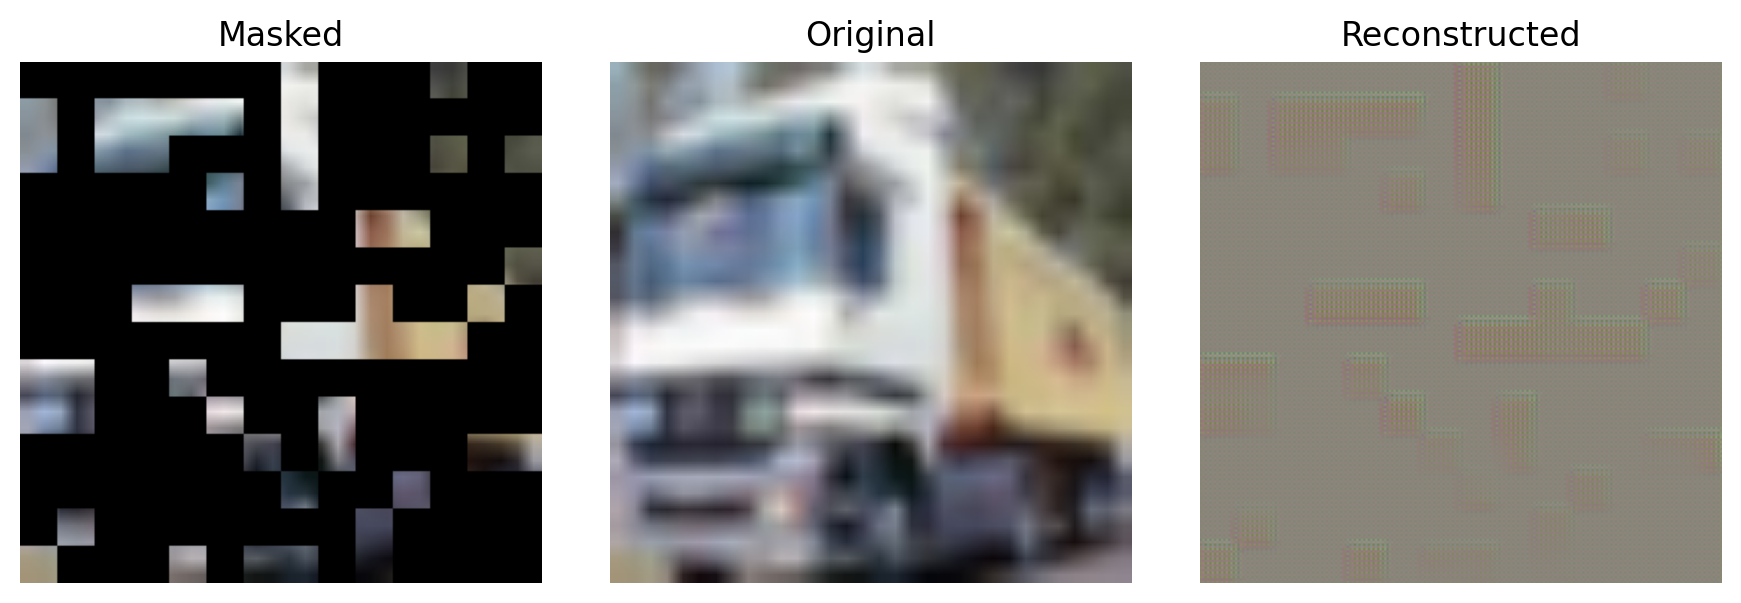

In [76]:
model = SkipAutoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()
visualize_reconstruction(model, train_pmask, idx=1, device=device)

In [77]:
train_autoencoder(model, train_loader, optimizer, criterion, device, epochs=15)

Epoch 1/15 | Train Loss: 0.0412
Epoch 2/15 | Train Loss: 0.0267
Epoch 3/15 | Train Loss: 0.0239
Epoch 4/15 | Train Loss: 0.0220
Epoch 5/15 | Train Loss: 0.0208
Epoch 6/15 | Train Loss: 0.0198
Epoch 7/15 | Train Loss: 0.0192
Epoch 8/15 | Train Loss: 0.0180
Epoch 9/15 | Train Loss: 0.0180
Epoch 10/15 | Train Loss: 0.0174
Epoch 11/15 | Train Loss: 0.0168
Epoch 12/15 | Train Loss: 0.0159
Epoch 13/15 | Train Loss: 0.0156
Epoch 14/15 | Train Loss: 0.0150
Epoch 15/15 | Train Loss: 0.0150


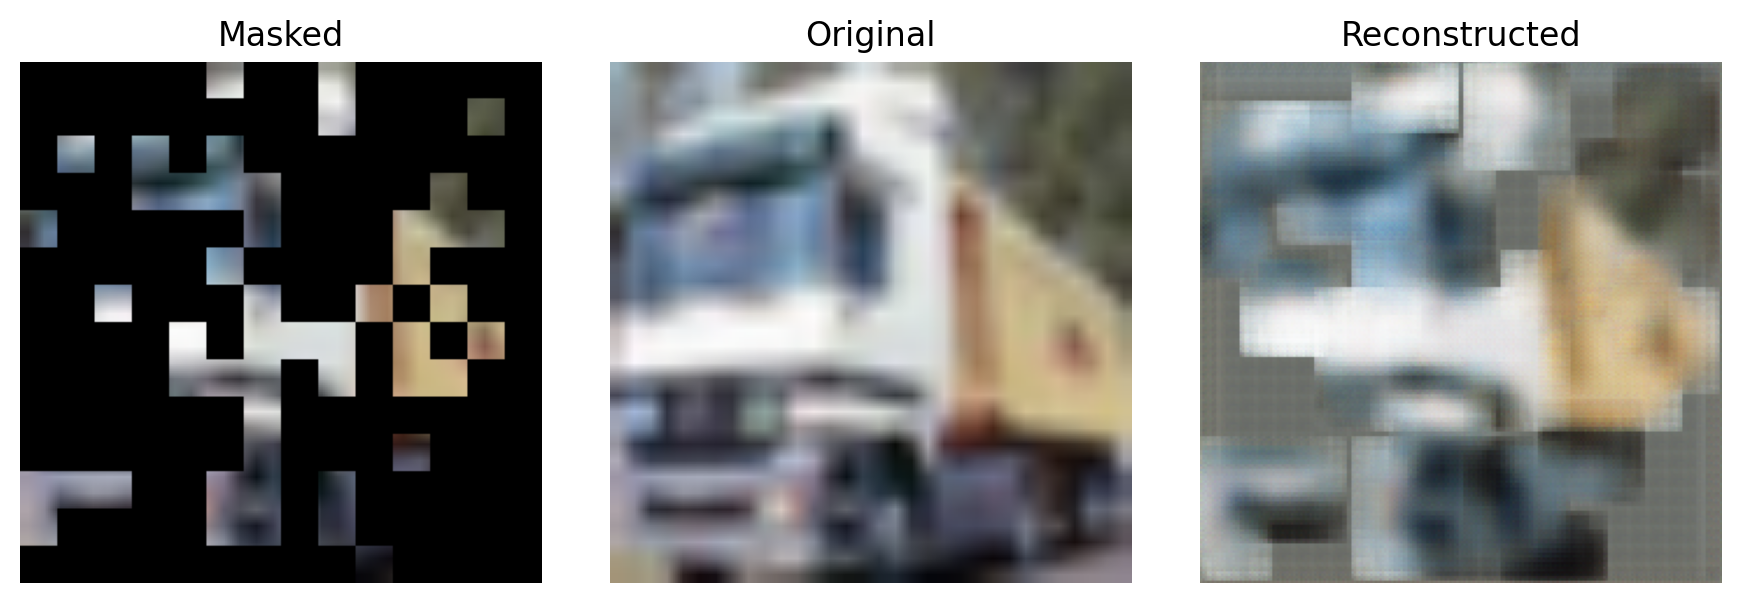

In [78]:
visualize_reconstruction(model, train_pmask, idx=1, device=device)